In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.io
import cartopy.io.img_tiles
import cartopy.feature
import shapely

import functions

## Define Variables

In [2]:
skip_ncgen_temp = False # set 'False' for the first run to save temporary processed netcdf files

bounds = [88.6875, 25.5, 93.375, 28.625] # covers the basin over Bhutan
bounds_bhutan = [88.6875, 26.6875, 92.125, 28.25] # covers Bhutan
date_range = ['1996-01-01','2019-12-31'] # for statistics

path_data = '/rcfs/projects/sage/hydro-modeling/datasets'
#path_data = 'datasets' # if there is a symlink created for the absolute path above
list_models = ['ERA5', 'ERA5-L', 'MSWX-P', 'GSWP3-W5E5', 'HMA', 'GMFD'] # a list of model variables
years_load = np.arange(1996, 2020) # for loading datasets
path_temps, path_figs = 'tempfiles', 'figures'
os.makedirs(path_temps, exist_ok = True)
os.makedirs(path_figs, exist_ok = True)

vars_list = {
    'ERA5': [
        't2m', # 2 metre temperature
        'tp', # Total precipitation
    ],
    'ERA5-L': [
        't2m', # 2 metre temperature
        'tp', # Total precipitation
    ],
    'MSWX-P': [
        'air_temperature',
        'air_temperature_max',
        'air_temperature_min',
        'precipitation',
    ],
    'GSWP3-W5E5': [
        'pr', # Precipitation
        'tas', # Near-Surface Air Temperature
        'tasmax', # Near-Surface Air Temperature
        'tasmin', # Near-Surface Air Temperature
    ],
    'HMA': [
        'P_CHP', # Downscaled CHIRPS total precipitation
        'P_ECMWF', # Downscaled ECMWF total precipitation
        'Tair', # Downscaled ECMWF near-surface temperature
    ],
    'GMFD': [
        'prcp', # Precipitation
        'tas', # Air temperature
        'tmax', # Maximum air temperature
        'tmin', # Minimum air temperature
    ],
}
key_temp = {'ERA5': 't2m', 'ERA5-L': 't2m', 'HMA': 'Tair'} # sub-daily temperature variables in each model
key_tmin = {'MSWX-P': 'air_temperature_min', 'GSWP3-W5E5': 'tasmin', 'GMFD': 'tmin'} # daily minimum temperature variables in each model
key_tmax = {'MSWX-P': 'air_temperature_max', 'GSWP3-W5E5': 'tasmax', 'GMFD': 'tmax'} # daily maximum temperature variables in each model

## Load Datasets

In [3]:
list_ds = []
if not skip_ncgen_temp:
    for m in list_models:
        ds = functions.read_datasets(path = path_data, model = m, years = years_load, bounds = bounds, vars_list = vars_list[m], save_nc = None)
        if m in key_temp.keys(): ds[key_temp[m]] = functions.convert_temperature(da_temp = ds[key_temp[m]], model = m) # convert a sub-daily temperature variable into degreeC
        if m in key_tmin.keys(): ds[key_tmin[m]] = functions.convert_temperature(da_temp = ds[key_tmin[m]], model = m) # convert a daily minimum temperature variable into degreeC
        if m in key_tmax.keys(): ds[key_tmax[m]] = functions.convert_temperature(da_temp = ds[key_tmax[m]], model = m) # convert a daily maximum temperature variable into degreeC
        list_ds.append(ds)

In [4]:
list_name_temp, list_da_atmean, list_da_tmin, list_da_mtmin, list_da_mtmax, list_da_afrostday = [], [], [], [], [], []
list_da_atdiff, list_da_mtdiff = [], []
if not skip_ncgen_temp:
    for i, m in enumerate(list_models):
        # Figure 12: Mean Annual Temperature
        if m in key_temp.keys():
            list_name_temp.append(f'{functions.models_name[m]}: "{key_temp[m]}"')
            da = list_ds[i][key_temp[m]].resample(time = '1YS', skipna = False).mean() # Annual Mean if the sub-hourly data are available
        elif m in key_tmin.keys() and m in key_tmax.keys():
            list_name_temp.append(f'{functions.models_name[m]}: "{key_tmin[m]}, {key_tmax[m]}"')
            da = (list_ds[i][key_tmin[m]] + list_ds[i][key_tmax[m]]) / 2  # Average of Tmax and Tmin if the sub-hourly data are unavailable, similar to the paper
            da = da.resample(time = '1YS', skipna = False).mean() # Annual Mean
            da.name = key_tmin[m][0].replace('min','mean_by_minmax')
        date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da['time'][0].values))
        date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da['time'][-1].values))
        da_atmean = da.sel(time = pd.date_range(date_min, date_max, freq = '1YS')).mean(dim = 'time') # Mean
        da_atmean.to_netcdf(os.path.join(path_temps, f'_ncgen_Fig12_tmean_{m}.nc'))
        list_da_atmean.append(da_atmean)

        # Figure 13: Mean Daily Minimum Temperature
        if m in key_temp.keys(): da_min = list_ds[i][key_temp[m]].resample(time = '1D', skipna = False).min() # Daily Minimum Temperature
        elif m in key_tmin.keys() and m in key_tmax.keys(): da_min = list_ds[i][key_tmin[m]]
        date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da_min['time'][0].values))
        date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da_min['time'][-1].values))
        da_mtmin = da_min.sel(time = pd.date_range(date_min, date_max, freq = '1D')).groupby('time.month').mean() # Mean by Month
        da_mtmin.to_netcdf(os.path.join(path_temps, f'_ncgen_Fig13_tmin_{m}.nc'))
        list_da_mtmin.append(da_mtmin)
        
        # Figure 14: Mean Annual Frost Days (< 0 degC)
        da_afrostday = da_min.sel(time = pd.date_range(date_min, date_max, freq = '1D')).compute()
        da_afrostday = np.isfinite(da_afrostday.where(da_afrostday < 0)).resample(time = '1YS').sum().mean('time') # count annual frost days lower than 1 degC and average
        da_afrostday.to_netcdf(os.path.join(path_temps, f'_ncgen_Fig14_frostday_{m}.nc'))
        list_da_afrostday.append(da_afrostday)
        
        # Figure 13: Mean Daily Maximum Temperature
        if m in key_temp.keys(): da_max = list_ds[i][key_temp[m]].resample(time = '1D', skipna = False).max() # Daily Maximum Temperature
        elif m in key_tmin.keys() and m in key_tmax.keys(): da_max = list_ds[i][key_tmax[m]]
        date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da_max['time'][0].values))
        date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da_max['time'][-1].values))
        da_mtmax = da_max.sel(time = pd.date_range(date_min, date_max, freq = '1D')).groupby('time.month').mean() # Mean by Month
        da_mtmax.to_netcdf(os.path.join(path_temps, f'_ncgen_Fig13_tmax_{m}.nc'))
        list_da_mtmax.append(da_mtmax)

        # Figure 15: Mean Annual Temperature Difference
        da_atdiff = da_max.resample(time = '1YS', skipna = False).max() - da_min.resample(time = '1YS', skipna = False).min() # Annual Temperature Difference
        date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da_atdiff['time'][0].values))
        date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da_atdiff['time'][-1].values))
        da_atdiff = da_atdiff.sel(time = pd.date_range(date_min, date_max, freq = '1YS')).mean(dim = 'time') # Mean
        da_atdiff.to_netcdf(os.path.join(path_temps, f'_ncgen_Fig15_tdiffmean_{m}.nc'))
        list_da_atdiff.append(da_atdiff)
        
        # Figure 16: Mean Daily Temperature Difference
        da_mtdiff = da_max - da_min # Daily Temperature Difference
        date_min = max(pd.Timestamp(date_range[0]), pd.Timestamp(da_mtdiff['time'][0].values))
        date_max = min(pd.Timestamp(date_range[-1]), pd.Timestamp(da_mtdiff['time'][-1].values))
        da_mtdiff = da_mtdiff.sel(time = pd.date_range(date_min, date_max, freq = '1D')).groupby('time.month').mean() # Mean by Month
        da_mtdiff.to_netcdf(os.path.join(path_temps, f'_ncgen_Fig16_tdiff_{m}.nc'))
        list_da_mtdiff.append(da_mtdiff)
else:
    for i, m in enumerate(list_models):
        if m in key_temp.keys(): list_name_temp.append(f'{functions.models_name[m]}: "{key_temp[m]}"')
        elif m in key_tmin.keys() and m in key_tmax.keys(): list_name_temp.append(f'{functions.models_name[m]}: "{key_tmin[m]}, {key_tmax[m]}"')
        list_da_atmean.append(xr.load_dataarray(os.path.join(path_temps, f'_ncgen_Fig12_tmean_{m}.nc'), decode_coords = 'all'))
        list_da_mtmin.append(xr.load_dataarray(os.path.join(path_temps, f'_ncgen_Fig13_tmin_{m}.nc'), decode_coords = 'all'))
        list_da_afrostday.append(xr.load_dataarray(os.path.join(path_temps, f'_ncgen_Fig14_frostday_{m}.nc'), decode_coords = 'all'))
        list_da_mtmax.append(xr.load_dataarray(os.path.join(path_temps, f'_ncgen_Fig13_tmax_{m}.nc'), decode_coords = 'all'))
        list_da_atdiff.append(xr.load_dataarray(os.path.join(path_temps, f'_ncgen_Fig15_tdiffmean_{m}.nc'), decode_coords = 'all'))
        list_da_mtdiff.append(xr.load_dataarray(os.path.join(path_temps, f'_ncgen_Fig16_tdiff_{m}.nc'), decode_coords = 'all'))

## Set Plot Properties

In [5]:
shp_file = os.path.join('shapefiles', 'btn_admbnda_adm1_bnlc_20201026.shp') # Bhutan Administrative Boundaries (Level 1)
shp_file_mask = os.path.join('shapefiles', 'gridmask_bhutan.shp') # Polygon masking outside of Bhutan

baseMap = cartopy.io.img_tiles.GoogleTiles(style = 'satellite')

shape_feature = cartopy.feature.ShapelyFeature(cartopy.io.shapereader.Reader(shp_file).geometries(), crs = cartopy.crs.PlateCarree(), facecolor = 'none', linewidth = 0.5) # Bhutan Administrative Boundaries (Level 1)
shape_feature_mask = cartopy.feature.ShapelyFeature(cartopy.io.shapereader.Reader(shp_file_mask).geometries(), crs = cartopy.crs.PlateCarree(), facecolor = 'w', linewidth = 0.5) # masking outside of Bhutan
polygon_feature = shapely.unary_union(shapely.geometry.MultiPolygon(shape_feature.geometries())) # applying statistics only for Bhutan

# function to create a masked dataarray for statistics
def create_da_masked(da, polygon = None):
    if polygon is None: return da
    if 'lon' in da.dims and 'lat' in da.dims: x, y = 'lon', 'lat'
    elif 'longitude' in da.dims and 'latitude' in da.dims: x, y = 'longitude', 'latitude'
    elif 'x' in da.dims and 'y' in da.dims: x, y = 'x', 'y'
    else: return da
    xs, ys = np.meshgrid(da[x], da[y])
    xys = np.stack([xs.flatten(), ys.flatten()], axis = -1)
    mask = shapely.contains_xy(polygon, xys)
    mask = mask.reshape([len(da[y]), len(da[x])])
    return da.where(mask == True)

# function to plot a geospatial map of variable
def plot_models(list_da, list_name, list_shapes, bounds, norm = None, cmap = 'nipy_spectral', suptitle = '', clabel = '', stats = False, stats_polygon = None, stats_unit = 'mm', savefig = None, show = True):
    nplot = len(list_da)
    fig, axes = plt.subplots(nrows = (1 + nplot) // 2, ncols = 2, figsize = (10, 10), subplot_kw = {'projection': baseMap.crs})
    fig.suptitle(suptitle)
    for i, ax in enumerate(axes.flat):
        ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])
        fgl = ax.gridlines(crs = cartopy.crs.PlateCarree(), linestyle = '--', alpha = 0.25, draw_labels = True)
        fgl.top_labels, fgl.right_labels = False, False
        fgl.xlabel_style, fgl.ylabel_style = {'color': 'gray', 'size': 8}, {'color': 'gray', 'size': 8}

        if i < nplot:
            fda = list_da[i].plot(ax = ax, transform = cartopy.crs.PlateCarree(), norm = norm, cmap = cmap, add_colorbar = False)
            
            if stats == True or stats_polygon is not None: # applying statistics only for Bhutan
                da_masked = create_da_masked(da = list_da[i], polygon = stats_polygon)
                stats = 'Mean: {:.0f} {}, Min: {:.0f} {}, Max: {:.0f} {}'.format(np.nanmean(da_masked), stats_unit, np.nanmin(da_masked), stats_unit, np.nanmax(da_masked), stats_unit)
                ax.set_title(list_name[i] + '\n' + stats)
            else: ax.set_title(list_name[i])
        else: ax.add_image(baseMap, 10)
        for s in list_shapes: ax.add_feature(s)
        
    fig.subplots_adjust(bottom = 0.05)
    cax = fig.add_axes([0.2, 0.025, 0.6, 0.02])
    fig.colorbar(fda, label = clabel, cax = cax, orientation = 'horizontal')
    fig.tight_layout(rect = [0, 0.05, 1, 1])

    if savefig is not None: plt.savefig(savefig, bbox_inches = 'tight')
    if show is not None: plt.show()
    return

# colormaps
precip_11lev = np.array([
    [255, 255, 255],
    [237, 250, 194],
    [205, 255, 205],
    [153, 240, 178],
    [83, 189, 159],
    [50, 166, 150],
    [50, 150, 180],
    [5, 112, 176],
    [5, 80, 140],
    [10, 31, 150],
    [44, 2, 70],
    [106, 44, 90],
])
precip_11lev = precip_11lev / 255
prcp_bounds = [0, 1, 2, 5, 10, 20, 200, 300, 500, 1000]
prcp_norm = matplotlib.colors.BoundaryNorm(boundaries = prcp_bounds, ncolors = 13, extend = 'max')

prcp_bounds_temp = np.linspace(-3, 24, 10, endpoint = True)
prcp_norm_temp = matplotlib.colors.BoundaryNorm(boundaries = prcp_bounds_temp, ncolors = 256, extend = 'both')

prcp_bounds_tminmax = np.linspace(-15, 30, 10, endpoint = True)
prcp_norm_tminmax = matplotlib.colors.BoundaryNorm(boundaries = prcp_bounds_tminmax, ncolors = 256, extend = 'both')

prcp_bounds_frostday = [0, 0.5, 2, 10, 100, 200]
prcp_norm_frostday = matplotlib.colors.BoundaryNorm(boundaries = prcp_bounds_frostday, ncolors = 11, extend = 'both')

prcp_bounds_tdiffmean = np.linspace(24, 40, 5, endpoint = True)
prcp_norm_tdiffmean = matplotlib.colors.BoundaryNorm(boundaries = prcp_bounds_tdiffmean, ncolors = 256, extend = 'both')

prcp_bounds_tdiff = np.linspace(5, 17, 5, endpoint = True)
prcp_norm_tdiff = matplotlib.colors.BoundaryNorm(boundaries = prcp_bounds_tdiff, ncolors = 256, extend = 'both')

## Figure 12: Mean Annual Temperature

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


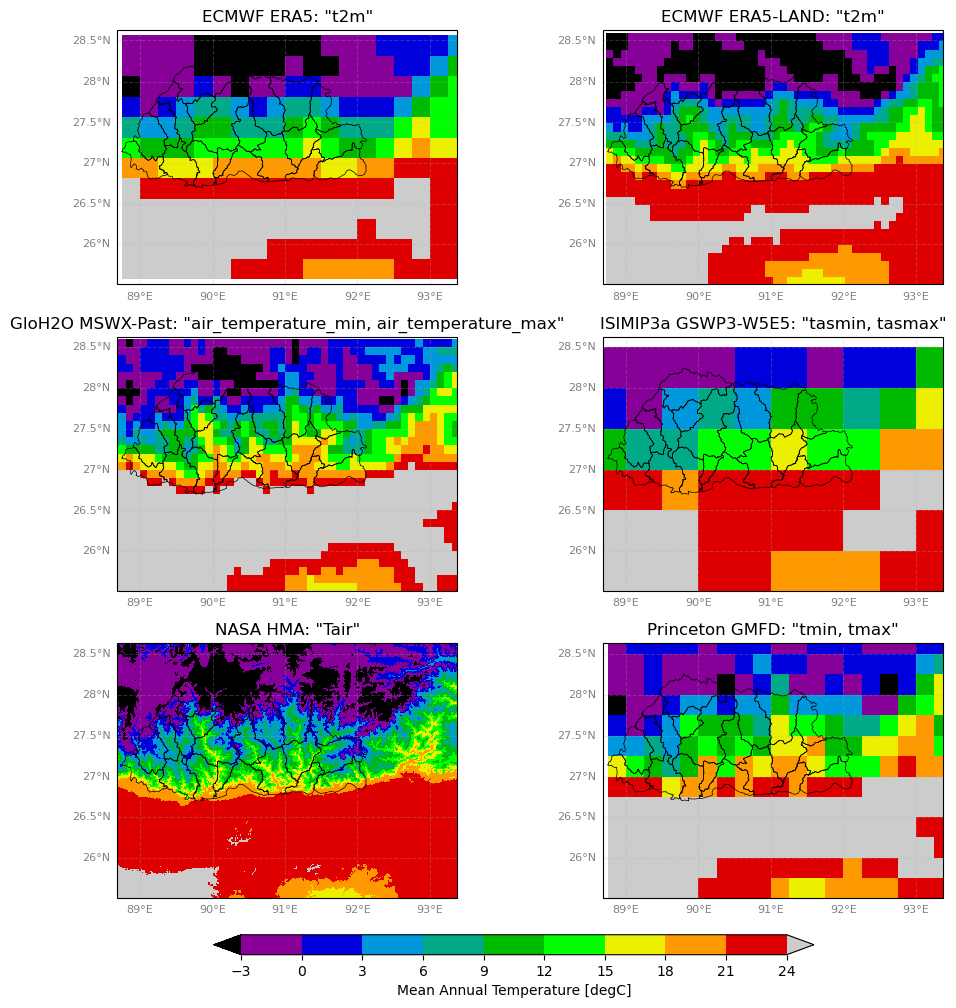

In [6]:
# Figure 12: Mean Annual Temperature (Basin)
plot_models(list_da = list_da_atmean, list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_temp, cmap = 'nipy_spectral', suptitle = '', clabel = 'Mean Annual Temperature [degC]',
            stats = False, stats_polygon = None, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig12-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


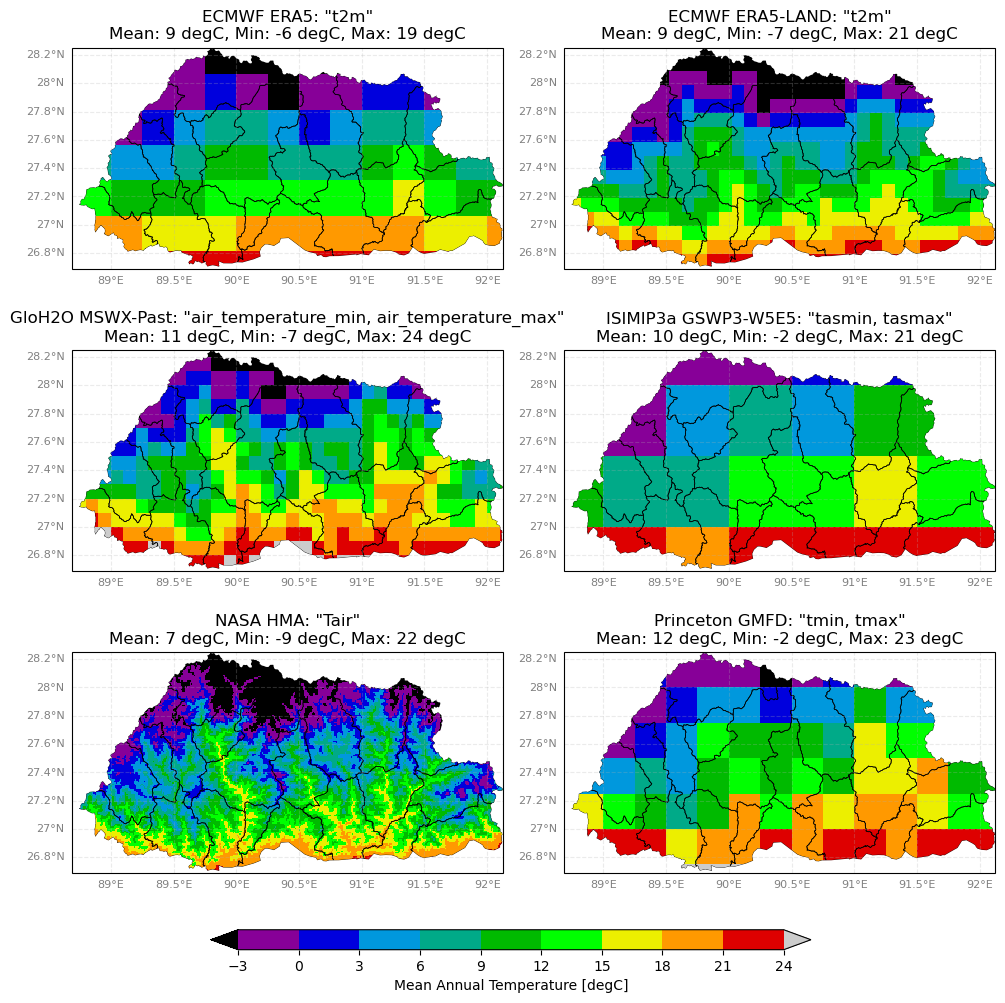

In [7]:
# Figure 12: Mean Annual Temperature (Bhutan) w/ statistics
plot_models(list_da = list_da_atmean, list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_temp, cmap = 'nipy_spectral', suptitle = '', clabel = 'Mean Annual Temperature [degC]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig12-Bhutan.png'), show = True)

## Figure 13a: Mean Daily Minimum Temperature: January

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


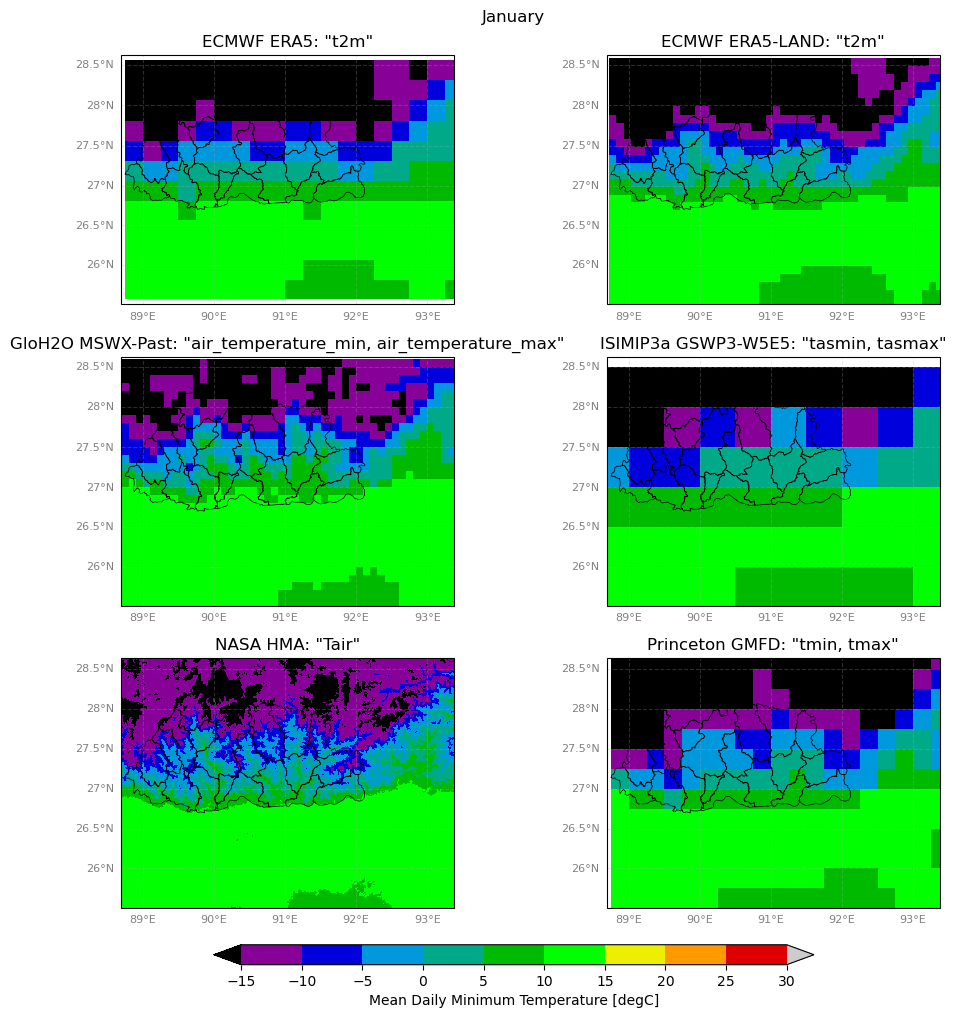

In [8]:
# Figure 13a: Mean Daily Minimum Temperature: January (Basin)
month = 1
plot_models(list_da = [da.sel(month = month) for da in list_da_mtmin], list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_tminmax, cmap = 'nipy_spectral', suptitle = 'January', clabel = 'Mean Daily Minimum Temperature [degC]',
            stats = False, stats_polygon = None, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig13-Tmin-Jan-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


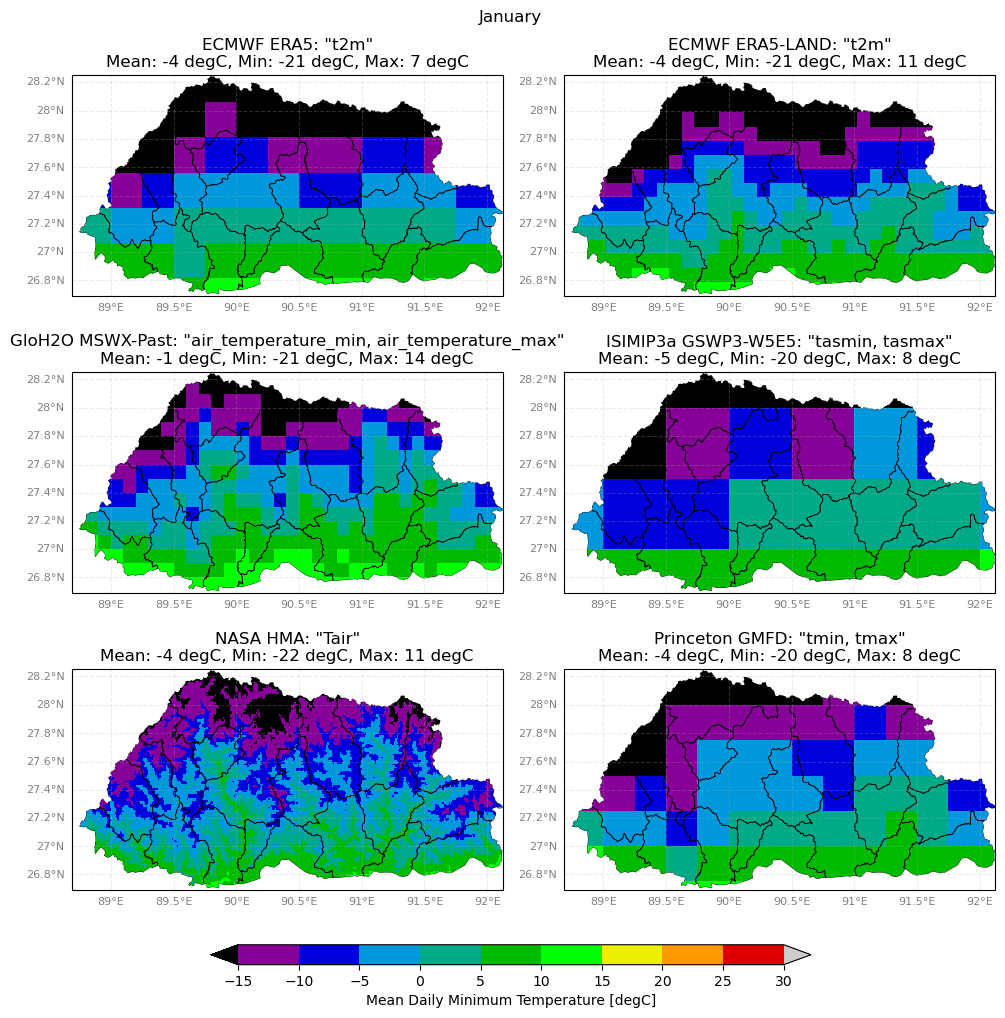

In [9]:
# Figure 13a: Mean Daily Minimum Temperature: January (Bhutan) w/ statistics
month = 1
plot_models(list_da = [da.sel(month = month) for da in list_da_mtmin], list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_tminmax, cmap = 'nipy_spectral', suptitle = 'January', clabel = 'Mean Daily Minimum Temperature [degC]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig13-Tmin-Jan-Bhutan.png'), show = True)

## Figure 13b: Mean Daily Maximum Temperature: January

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


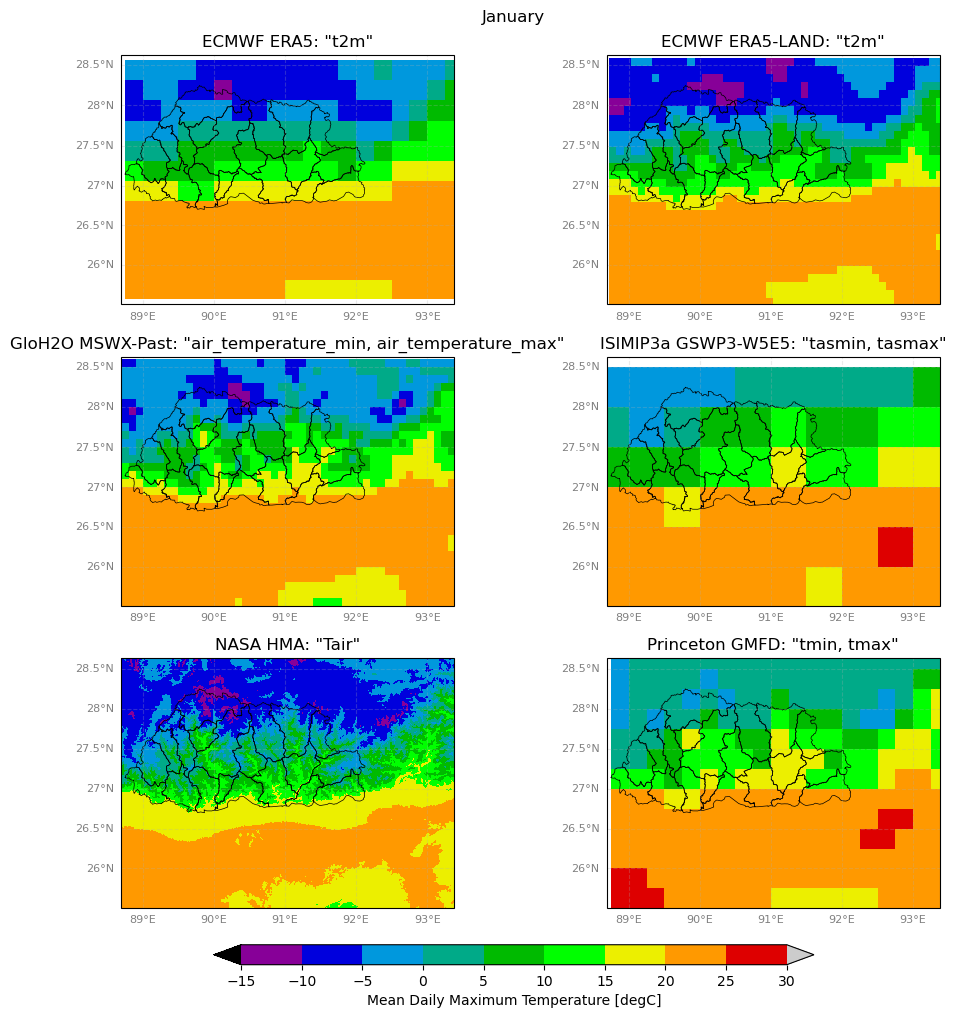

In [10]:
# Figure 13b: Mean Daily Maximum Temperature: January (Basin)
month = 1
plot_models(list_da = [da.sel(month = month) for da in list_da_mtmax], list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_tminmax, cmap = 'nipy_spectral', suptitle = 'January', clabel = 'Mean Daily Maximum Temperature [degC]',
            stats = False, stats_polygon = None, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig13-Tmax-Jan-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


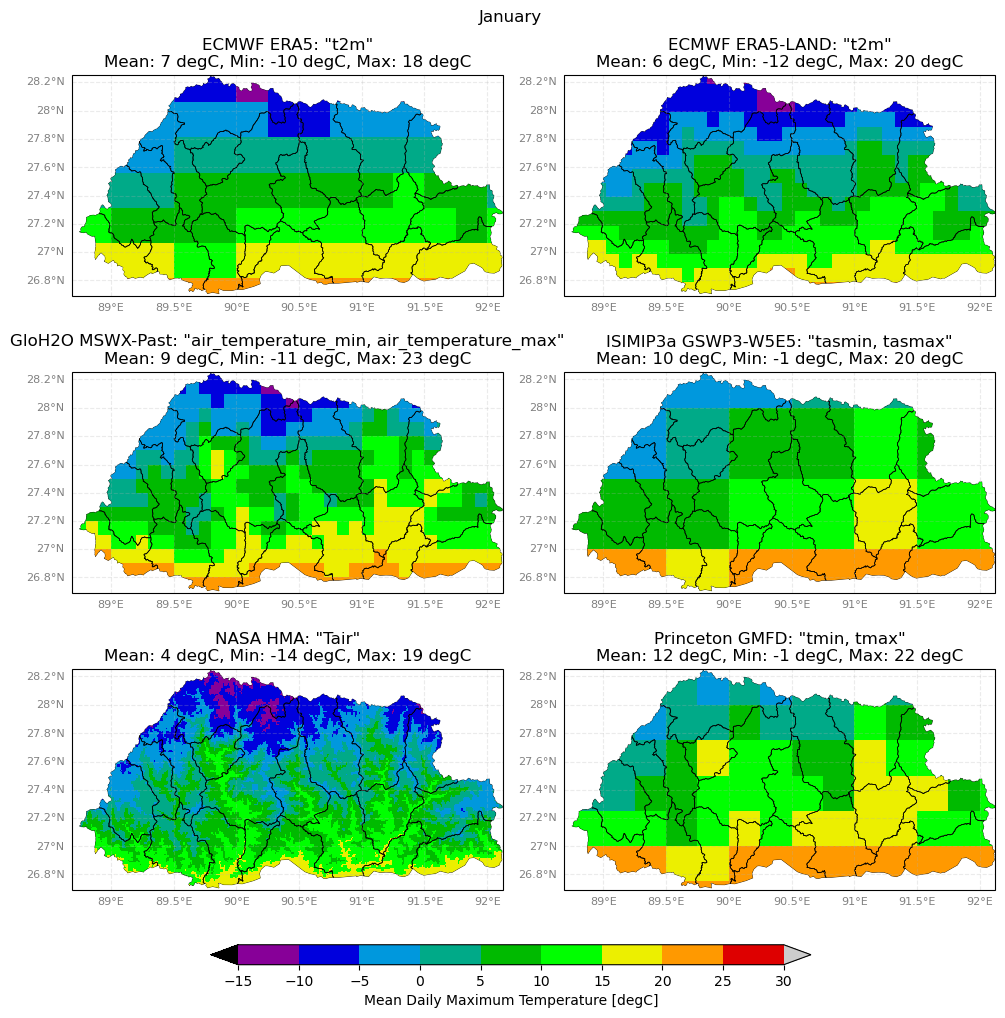

In [11]:
# Figure 13b: Mean Daily Maximum Temperature: January (Bhutan) w/ statistics
month = 1
plot_models(list_da = [da.sel(month = month) for da in list_da_mtmax], list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_tminmax, cmap = 'nipy_spectral', suptitle = 'January', clabel = 'Mean Daily Maximum Temperature [degC]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig13-Tmax-Jan-Bhutan.png'), show = True)

## Figure 13c: Mean Daily Minimum Temperature: July

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


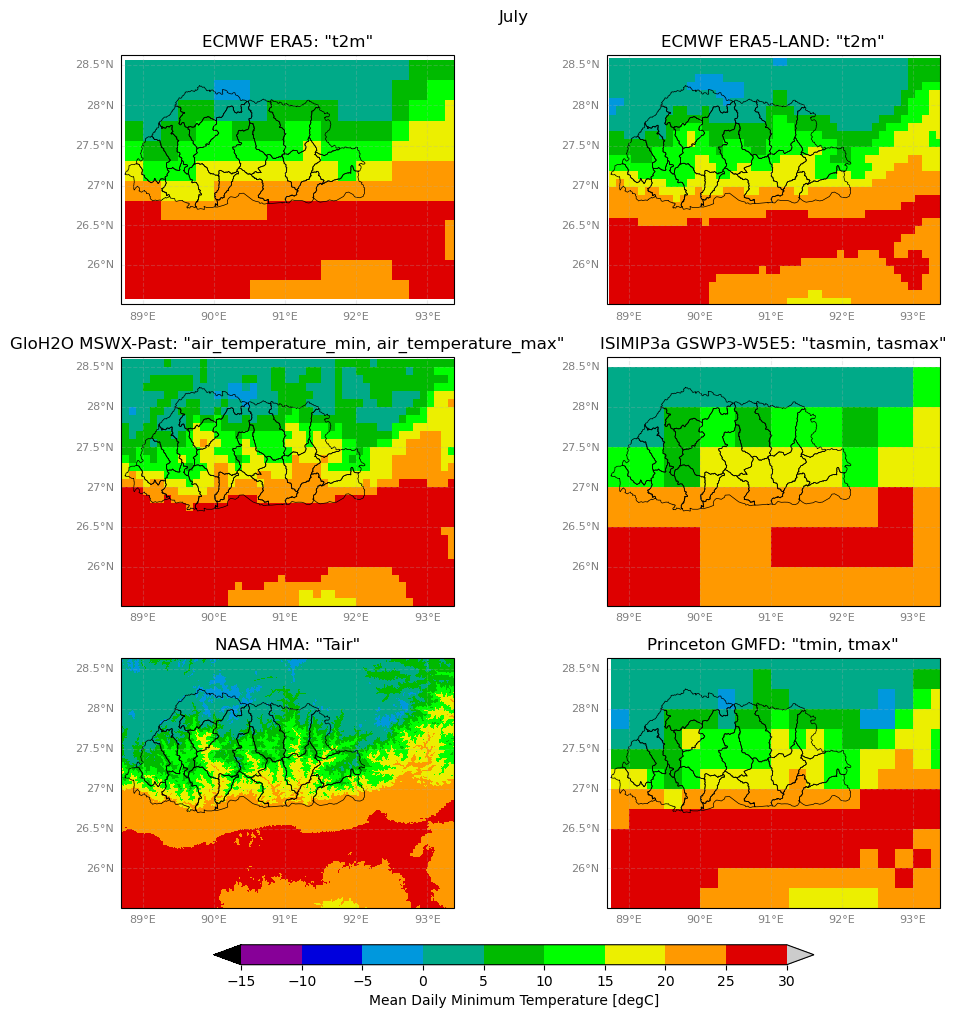

In [12]:
# Figure 13c: Mean Daily Minimum Temperature: July (Basin)
month = 7
plot_models(list_da = [da.sel(month = month) for da in list_da_mtmin], list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_tminmax, cmap = 'nipy_spectral', suptitle = 'July', clabel = 'Mean Daily Minimum Temperature [degC]',
            stats = False, stats_polygon = None, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig13-Tmin-July-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


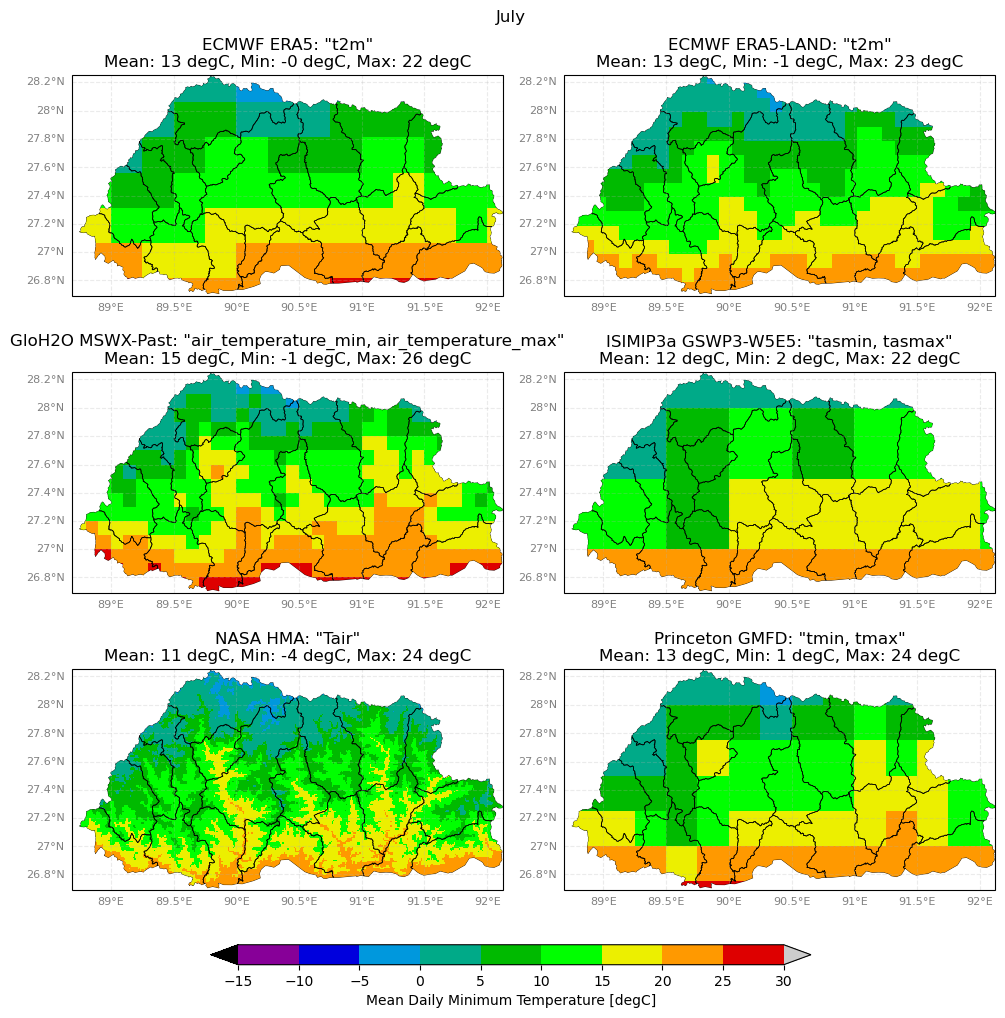

In [13]:
# Figure 13c: Mean Daily Minimum Temperature: July (Bhutan) w/ statistics
month = 7
plot_models(list_da = [da.sel(month = month) for da in list_da_mtmin], list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_tminmax, cmap = 'nipy_spectral', suptitle = 'July', clabel = 'Mean Daily Minimum Temperature [degC]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig13-Tmin-July-Bhutan.png'), show = True)

## Figure 13d: Mean Daily Maximum Temperature: July

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


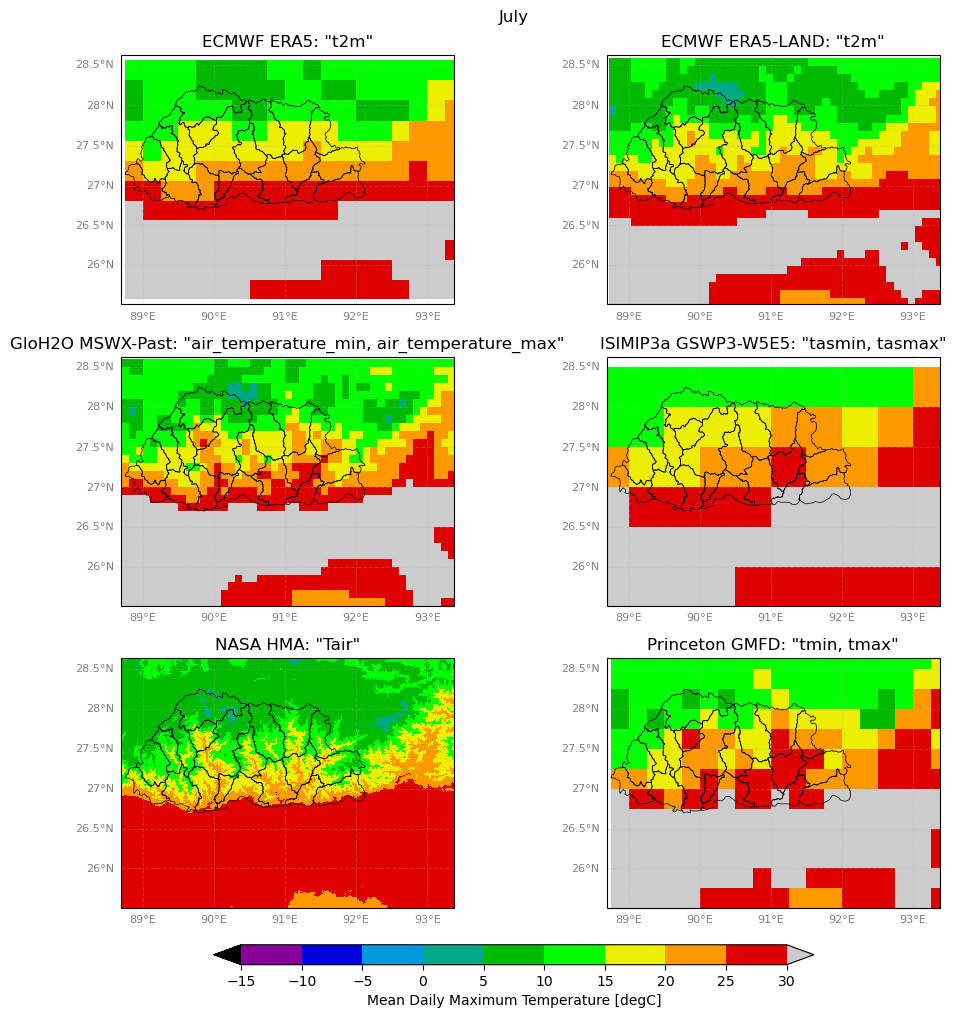

In [14]:
# Figure 13d: Mean Daily Maximum Temperature: July (Basin)
month = 7
plot_models(list_da = [da.sel(month = month) for da in list_da_mtmax], list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_tminmax, cmap = 'nipy_spectral', suptitle = 'July', clabel = 'Mean Daily Maximum Temperature [degC]',
            stats = False, stats_polygon = None, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig13-Tmax-July-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


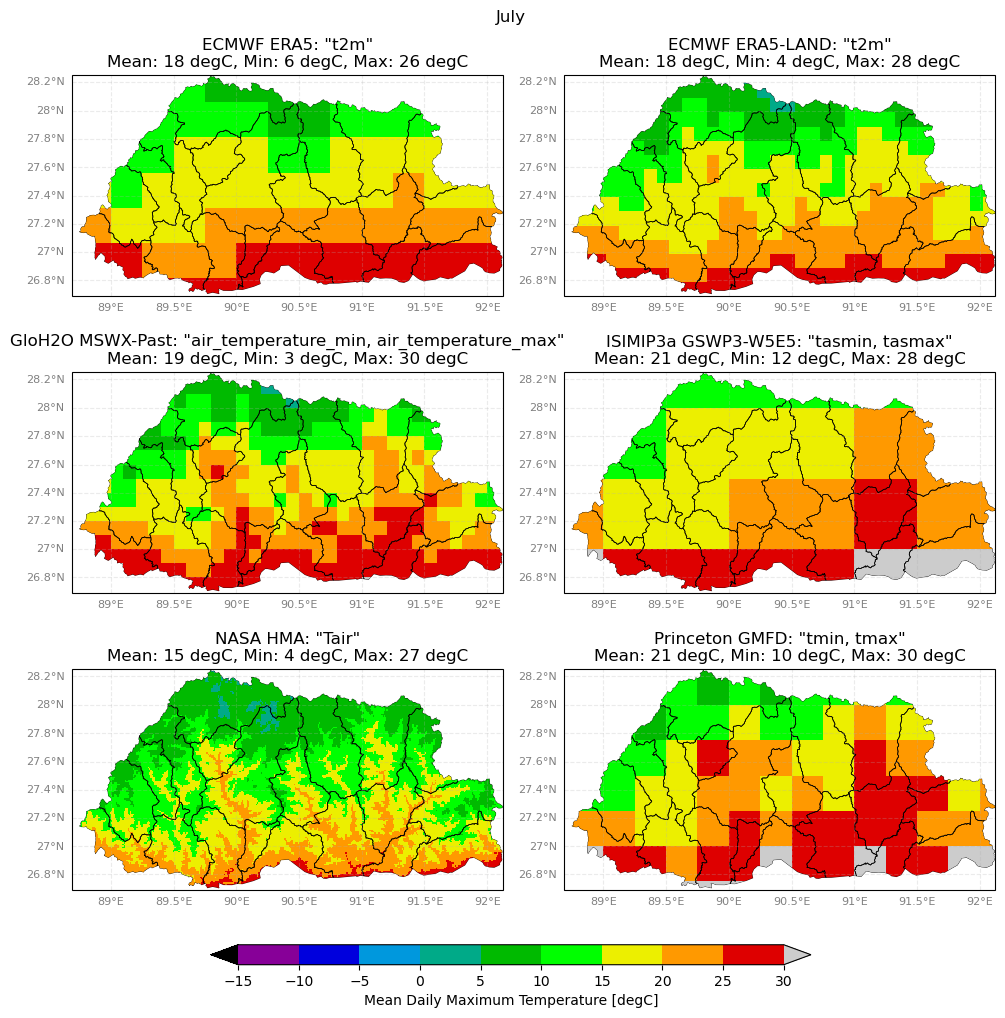

In [15]:
# Figure 13d: Mean Daily Maximum Temperature: July (Bhutan) w/ statistics
month = 7
plot_models(list_da = [da.sel(month = month) for da in list_da_mtmax], list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_tminmax, cmap = 'nipy_spectral', suptitle = 'July', clabel = 'Mean Daily Maximum Temperature [degC]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig13-Tmax-July-Bhutan.png'), show = True)

## Figure 14: Mean Annual Frost Days (< 0 degC)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


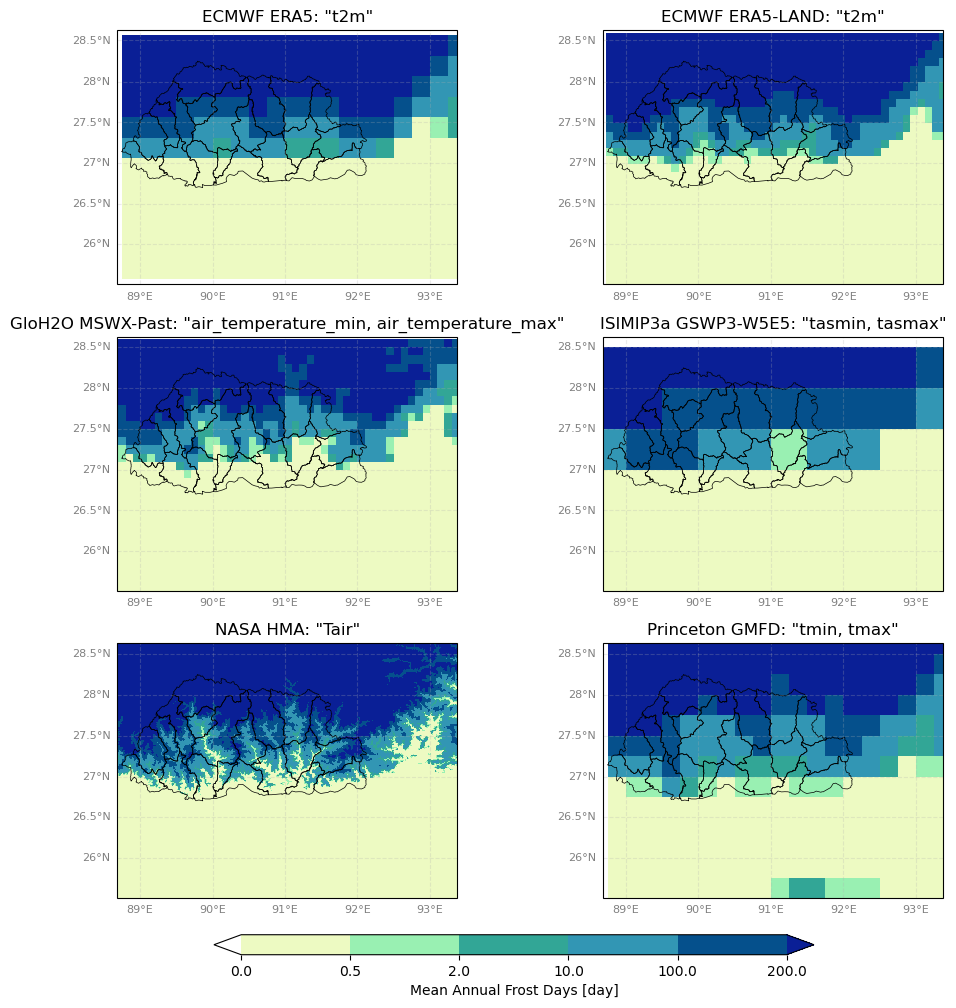

In [16]:
# Figure 14: Mean Annual Frost Days (< 0 degC, Basin)
plot_models(list_da = list_da_afrostday, list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_frostday, cmap = matplotlib.colors.ListedColormap(precip_11lev[:-2]), suptitle = '', clabel = 'Mean Annual Frost Days [day]',
            stats = False, stats_polygon = None, stats_unit = 'days',
            savefig = os.path.join(path_figs, 'Lehner-Fig14-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


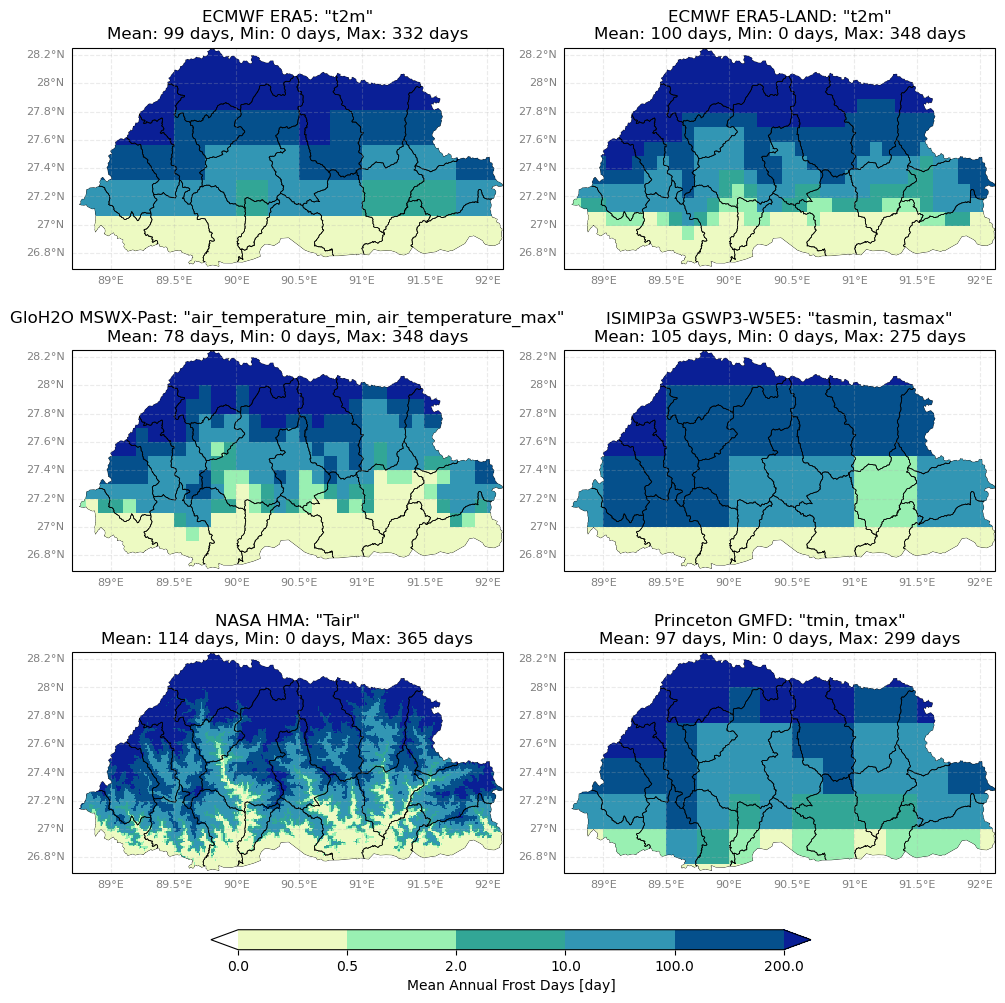

In [17]:
# Figure 14: Mean Annual Frost Days (< 0 degC, Bhutan) w/ statistics
plot_models(list_da = list_da_afrostday, list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_frostday, cmap = matplotlib.colors.ListedColormap(precip_11lev[:-2]), suptitle = '', clabel = 'Mean Annual Frost Days [day]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'days',
            savefig = os.path.join(path_figs, 'Lehner-Fig14-Bhutan.png'), show = True)

## Figure 15: Mean Annual Temperature Difference

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


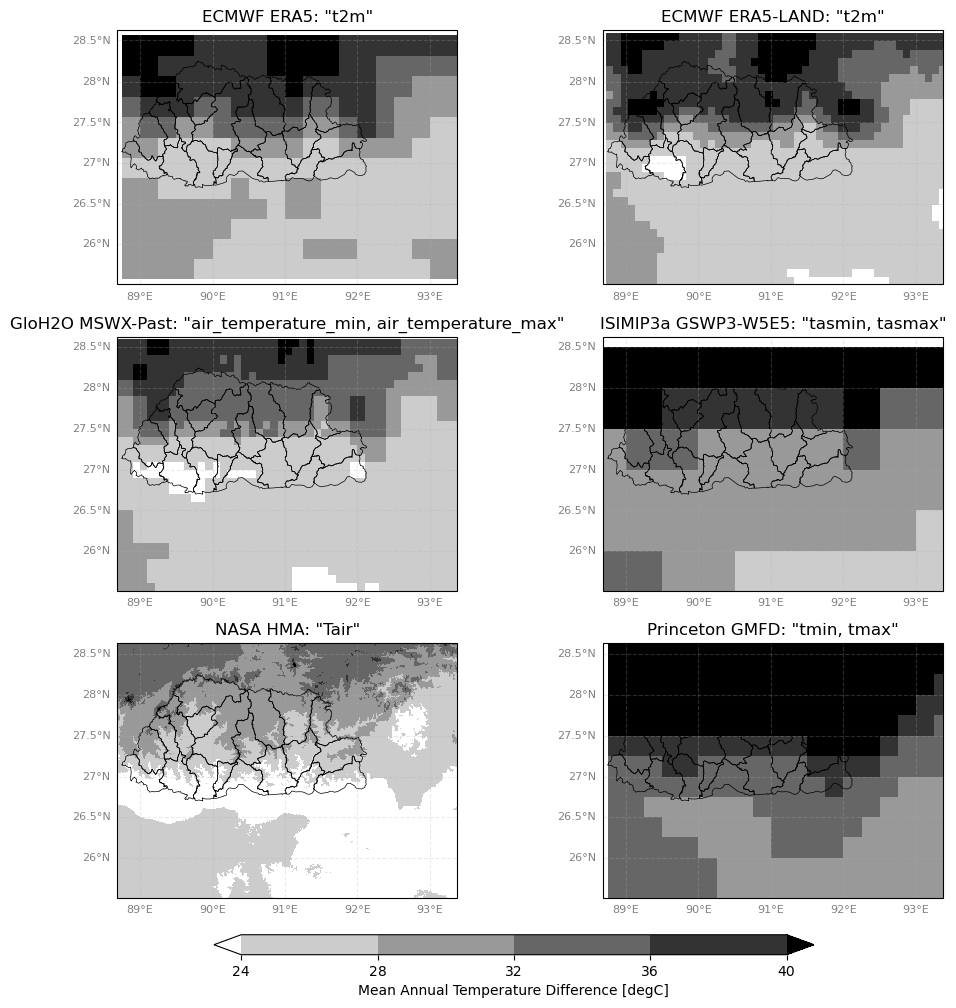

In [18]:
# Figure 15: Mean Annual Temperature Difference (Basin)
plot_models(list_da = list_da_atdiff, list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_tdiffmean, cmap = 'binary', suptitle = '', clabel = 'Mean Annual Temperature Difference [degC]',
            stats = False, stats_polygon = None, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig15-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


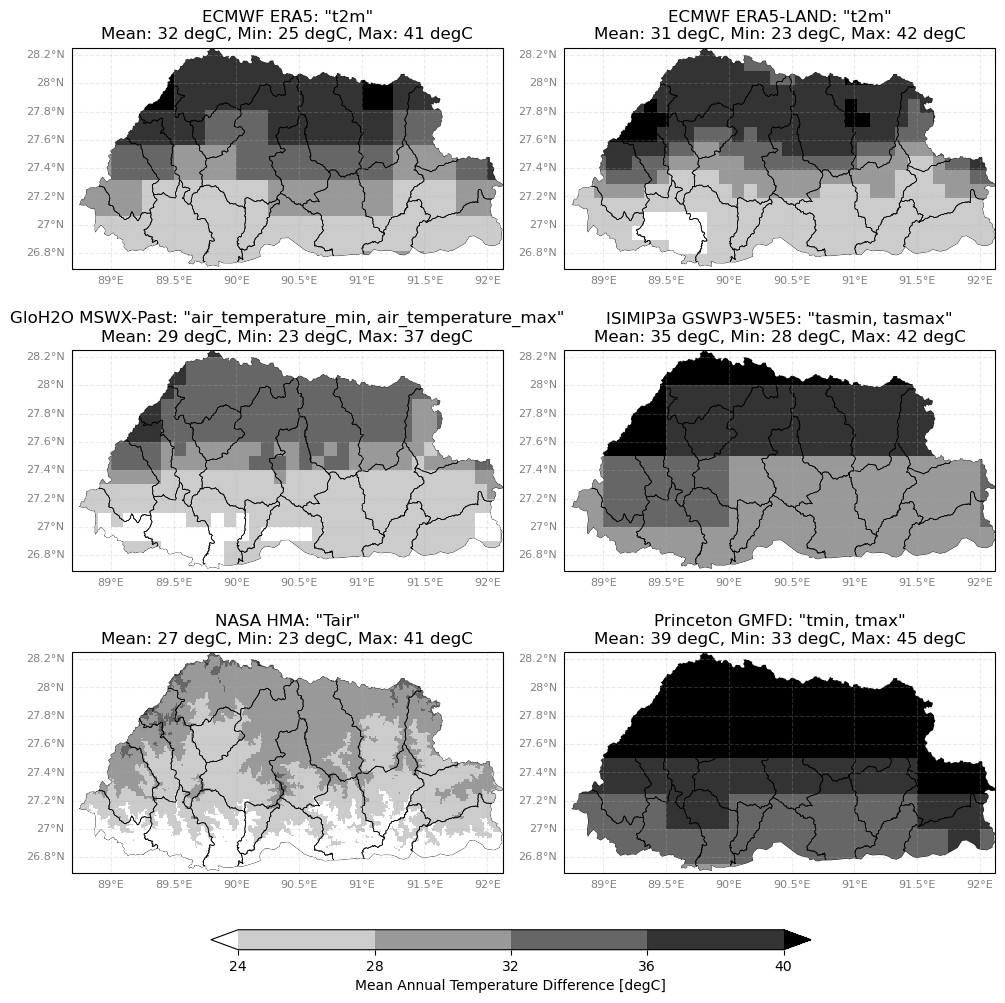

In [19]:
# Figure 15: Mean Annual Temperature Difference (Bhutan) w/ statistics
plot_models(list_da = list_da_atdiff, list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_tdiffmean, cmap = 'binary', suptitle = '', clabel = 'Mean Annual Temperature Difference [degC]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig15-Bhutan.png'), show = True)

## Figure 16a: Mean Daily Temperature Difference: January

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


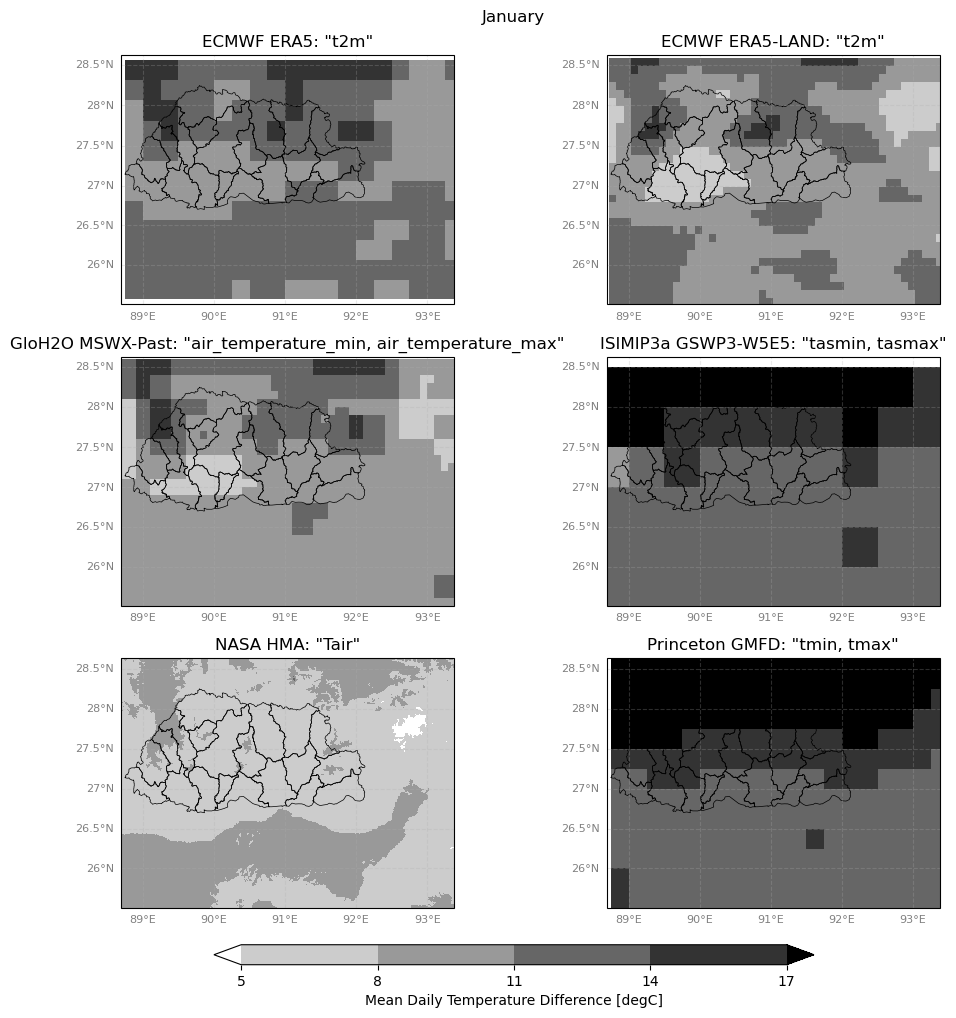

In [20]:
# Figure 16a: Mean Daily Temperature Difference: January (Basin)
month = 1
plot_models(list_da = [da.sel(month = month) for da in list_da_mtdiff], list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_tdiff, cmap = 'binary', suptitle = 'January', clabel = 'Mean Daily Temperature Difference [degC]',
            stats = False, stats_polygon = None, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig16-Jan-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


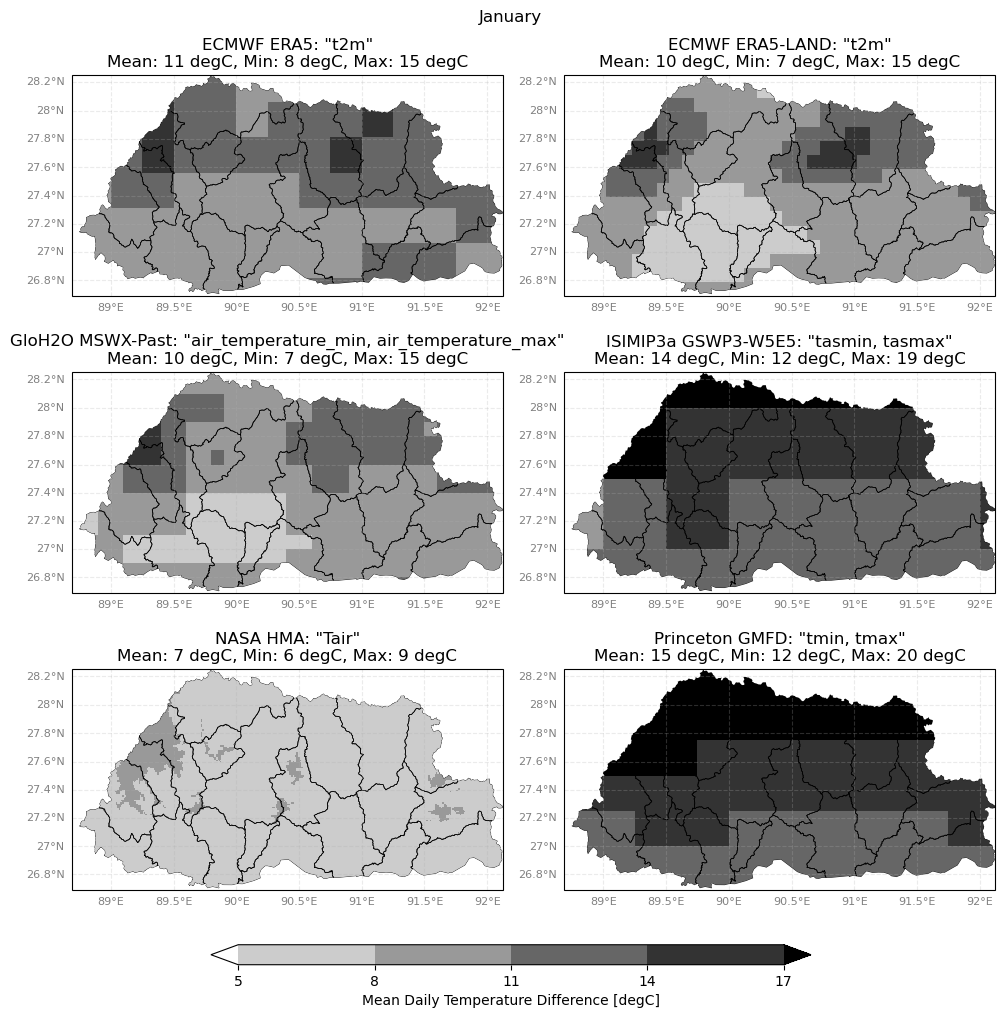

In [21]:
# Figure 16a: Mean Daily Temperature Difference: January (Bhutan) w/ statistics
month = 1
plot_models(list_da = [da.sel(month = month) for da in list_da_mtdiff], list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_tdiff, cmap = 'binary', suptitle = 'January', clabel = 'Mean Daily Temperature Difference [degC]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig16-Jan-Bhutan.png'), show = True)

## Figure 16b: Mean Daily Temperature Difference: July

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


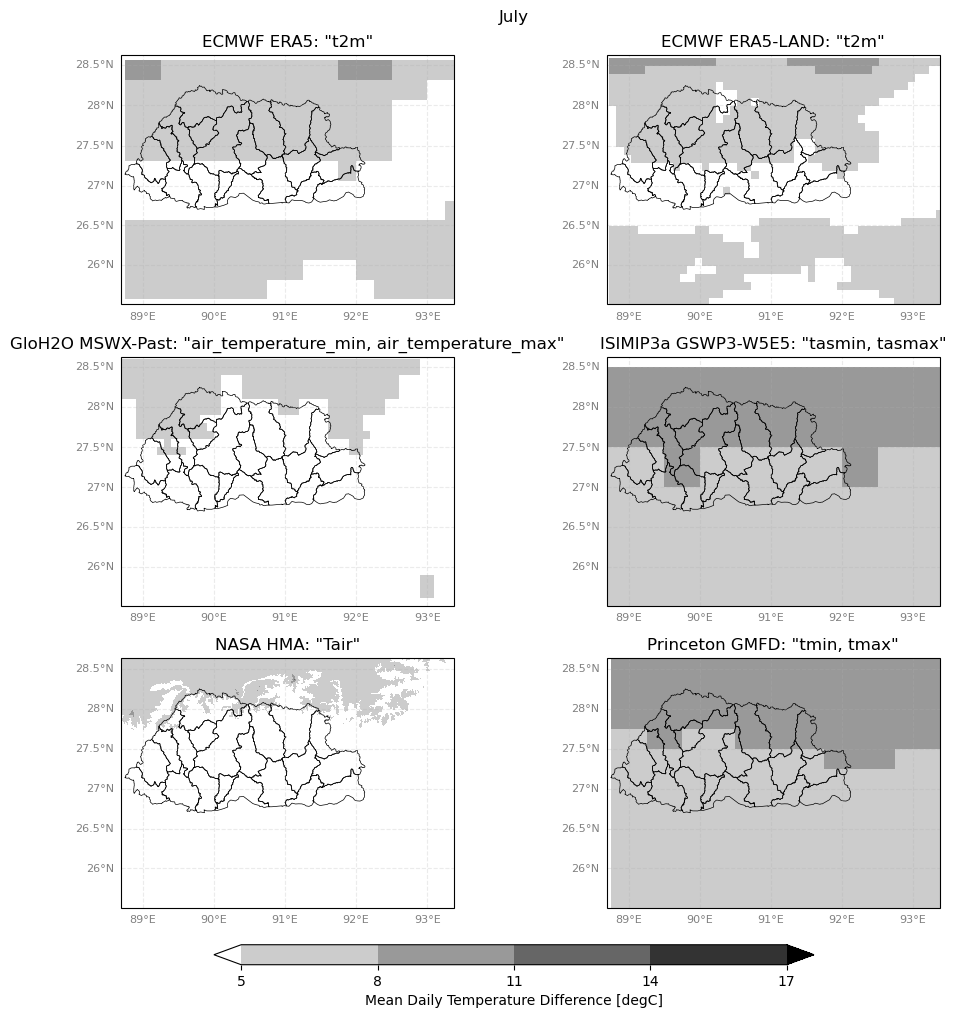

In [22]:
# Figure 16b: Mean Daily Temperature Difference: July (Basin)
month = 7
plot_models(list_da = [da.sel(month = month) for da in list_da_mtdiff], list_name = list_name_temp,
            list_shapes = [shape_feature], bounds = bounds,
            norm = prcp_norm_tdiff, cmap = 'binary', suptitle = 'July', clabel = 'Mean Daily Temperature Difference [degC]',
            stats = False, stats_polygon = None, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig16-July-Basin.png'), show = True)

/tmp/ipykernel_21892/3908550864.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect = [0, 0.05, 1, 1])


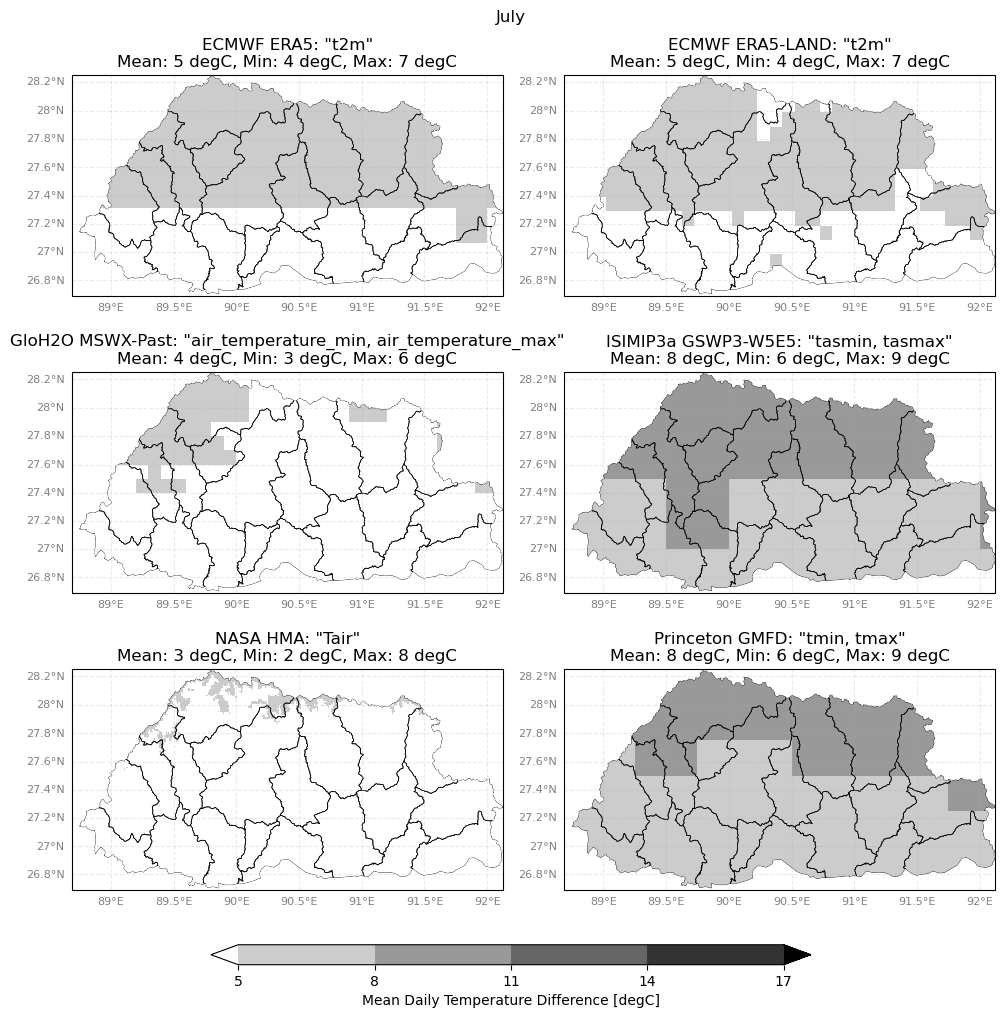

In [23]:
# Figure 16b: Mean Daily Temperature Difference: July (Bhutan) w/ statistics
month = 7
plot_models(list_da = [da.sel(month = month) for da in list_da_mtdiff], list_name = list_name_temp,
            list_shapes = [shape_feature, shape_feature_mask], bounds = bounds_bhutan,
            norm = prcp_norm_tdiff, cmap = 'binary', suptitle = 'July', clabel = 'Mean Daily Temperature Difference [degC]',
            stats = True, stats_polygon = polygon_feature, stats_unit = 'degC',
            savefig = os.path.join(path_figs, 'Lehner-Fig16-July-Bhutan.png'), show = True)